In [1]:
# Get the latest version of the data
!wget https://www.data.gouv.fr/fr/datasets/r/eceb9fb4-3ebc-4da3-828d-f5939712600a -O ../datagouv/department_latest.csv 2>/dev/null

    

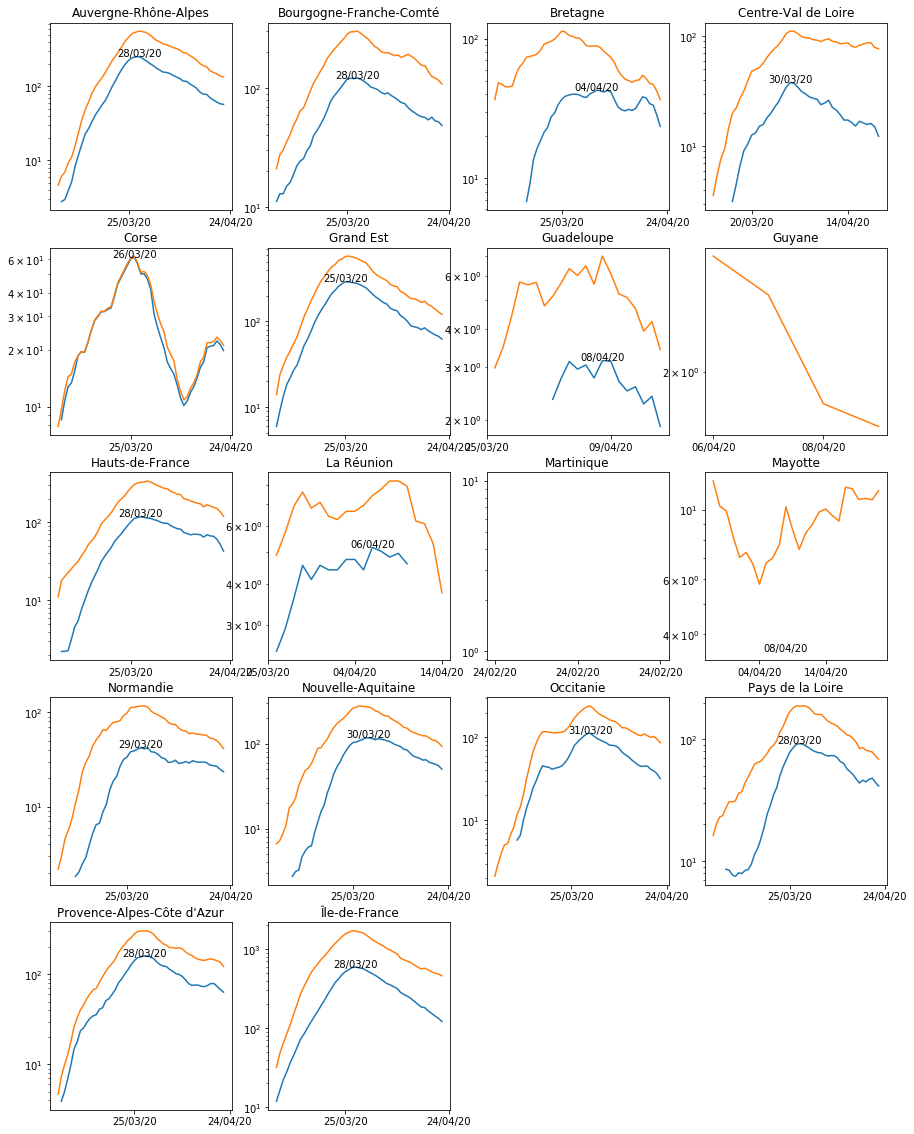

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

# Lire les données des urgences
df = pd.read_csv("../datagouv/department_latest.csv")
#extraire les données toutes classe d'age
all_age = df[df["sursaud_cl_age_corona"] == "0"].copy()

# Lire le fichier des régions
depts = pd.read_csv("../datagouv/regions.csv")
depts["num_dep"] = depts["num_dep"].apply(lambda x: x if len(x) > 1 else '0' + x)
depts.set_index(depts.num_dep, inplace=True)
depts.drop("num_dep",axis=1, inplace=True)


# Ajouter une colonne région dans les données des urgences
all_age["dep_name"] = all_age["dep"].apply(lambda x: depts.loc[str(x)].dep_name if pd.notnull(x) else None)
all_age["region_name"] = all_age["dep"].apply(lambda x: depts.loc[str(x)].region_name if pd.notnull(x) else None)


# Créer une table avec dates en lignes et régions en entrée
regions = pd.DataFrame()
regions["date_de_passage"] = all_age["date_de_passage"].unique()
regions.set_index("date_de_passage",inplace=True)


for r in all_age["region_name"].unique():
    if pd.isnull(r):
        continue
    r_all_age = all_age[all_age["region_name"] == r]
    r_all_age = r_all_age.groupby(["date_de_passage"]).agg('sum').copy()
    # Remplacer les valeurs nulles par na (pour ne pas perturber la vue en echelle logarithmique)
    r_all_age.loc[r_all_age["nbre_hospit_corona"] == 0,"nbre_hospit_corona"] = np.nan
    # Calculer la moyenne lissée
    r_all_age["rolling_hospit_corona"] = r_all_age["nbre_hospit_corona"].rolling(7,center=True).aggregate(lambda x: x.prod()**(1./7))
    
    # Nombre de passage
    r_all_age.loc[r_all_age["nbre_pass_corona"] == 0,"nbre_pass_corona"] = np.nan
    r_all_age["rolling_pass_corona"] = r_all_age["nbre_pass_corona"].rolling(7,center=True).aggregate(lambda x: x.prod()**(1./7))
        
    r_all_age["rolling_hospit_corona"] = r_all_age["nbre_hospit_corona"].rolling(7,center=True).aggregate(lambda x: x.prod()**(1./7))
    regions[r] = r_all_age["nbre_hospit_corona"]
    regions["%s_rolling"%r] = r_all_age["rolling_hospit_corona"]
    regions["%s_passages"%r] = r_all_age["rolling_pass_corona"]

# Convertir les dates maintenant qu'il n'y a plus de tri sur les dates
def convertDate(isodate):
    l = isodate.split('-')
    return l[2]+"/"+l[1]+"/"+l[0][2:]


regions["date"] = regions.index
regions["date"] = regions["date"].apply(convertDate)
regions = regions.set_index(["date"])
    
    
# Afficher une première courbe
fig = plt.figure(figsize=(15,20))

sorted_regions = [r for r in regions.columns if "rolling" not in r and "passage" not in r]
sorted_regions.sort()

i = 1
r = 5
c = 4
for reg in sorted_regions:
    ax = fig.add_subplot(r,c,i)
    #ax.plot(regions[reg], label=reg)
    ax.plot(regions["%s_rolling"%reg], label="rolling")
    ax.plot(regions["%s_passages"%reg], label="passages")
    ax.xaxis.set_major_locator(plt.MaxNLocator(2))
    # Détermination du pic des hospitalisations sur la courbe lissée
    peak = regions["%s_rolling"%reg].idxmax()
    if not pd.isnull(peak):
        peak_loc = regions.index.get_loc(peak)
        ax.text(peak_loc,regions["%s_rolling"%reg].loc[peak],peak,horizontalalignment="center")
    plt.yscale("log")
    ax.set_title(reg)
    i += 1
    



#No text output
None

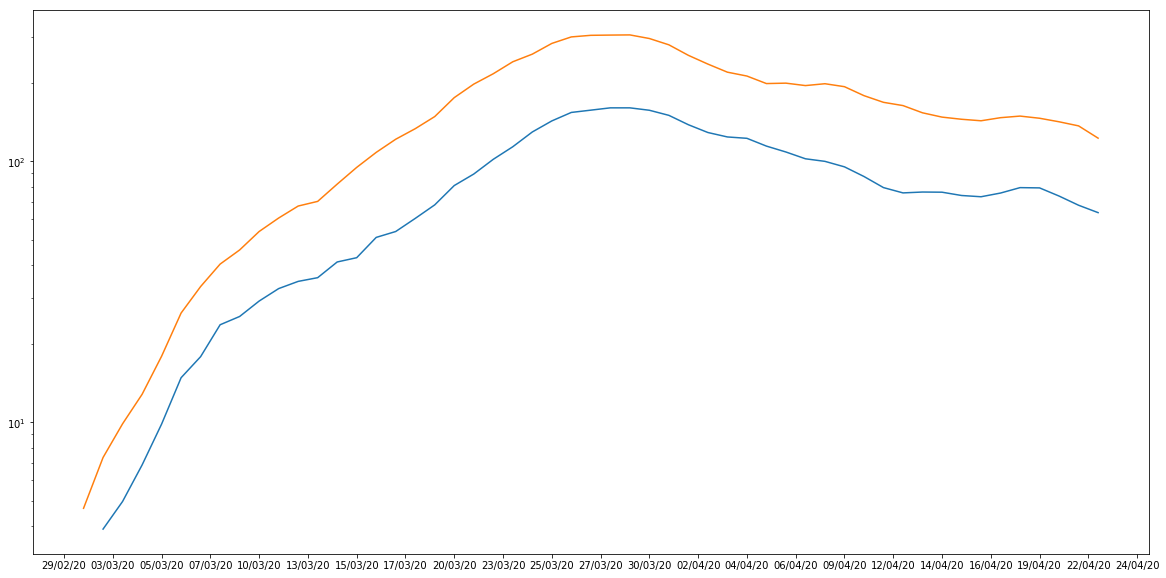

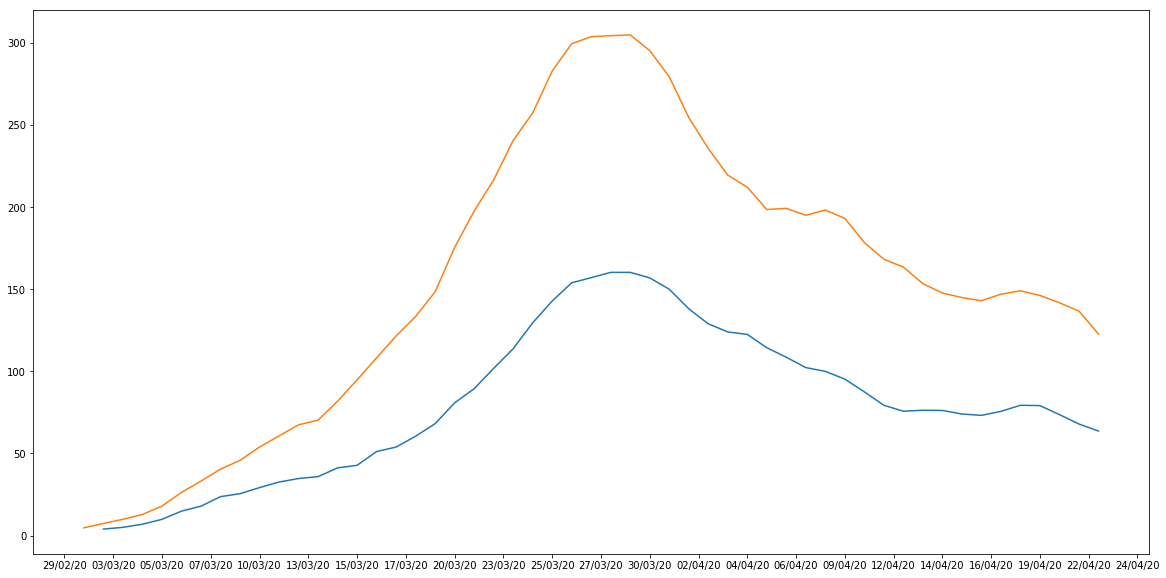

In [3]:

# Zoom sur Provence-Alpes-Côte d'Azur

reg="Provence-Alpes-Côte d'Azur"

fig = plt.figure(figsize=(20,10))

ax = plt.axes()
ax.plot(regions["%s_rolling"%reg], label="rolling")
ax.plot(regions["%s_passages"%reg], label="passages")
ax.xaxis.set_major_locator(plt.MaxNLocator(25))
plt.yscale("log")

fig = plt.figure(figsize=(20,10))
ax = plt.axes()
ax.plot(regions["%s_rolling"%reg], label="rolling")
ax.plot(regions["%s_passages"%reg], label="passages")
ax.xaxis.set_major_locator(plt.MaxNLocator(25))


None

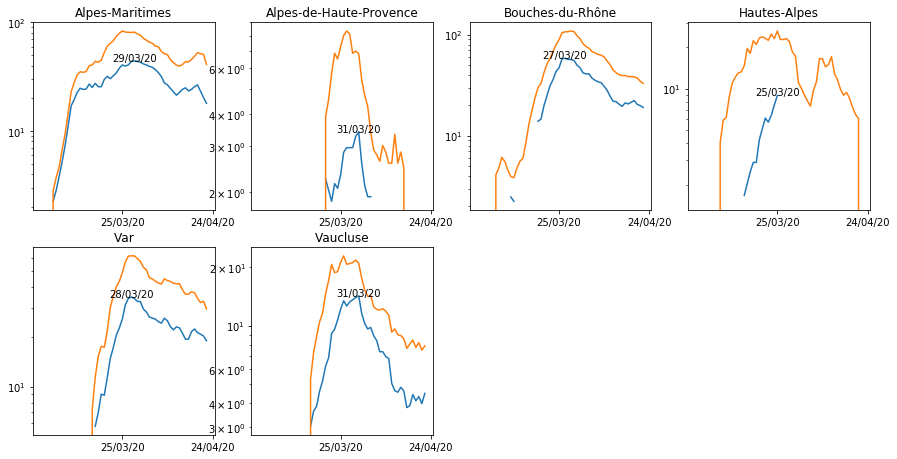

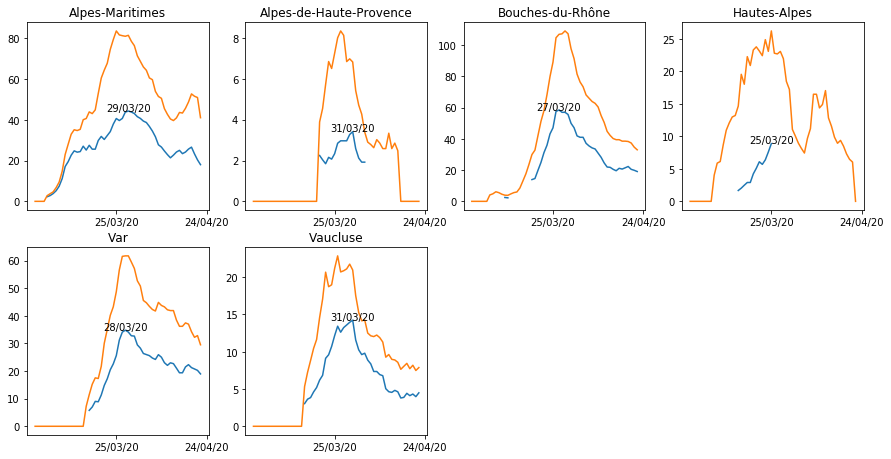

In [4]:
#Vue par département en PACA

# Créer une table avec dates en lignes et départements PACA en entrée
depts = pd.DataFrame()
depts["date_de_passage"] = all_age["date_de_passage"].unique()
depts.set_index("date_de_passage",inplace=True)

subset = all_age[all_age["region_name"] == "Provence-Alpes-Côte d'Azur"].copy()


for d in subset["dep_name"].unique():
    if pd.isnull(d):
        continue
    d_subset = subset[subset["dep_name"] == d]
    d_subset = d_subset.groupby(["date_de_passage"]).agg('sum').copy()
    # Remplacer les valeurs nulles par na (pour ne pas perturber la vue en echelle logarithmique)
    d_subset.loc[d_subset["nbre_hospit_corona"] == 0,"nbre_hospit_corona"] = np.nan
    # Calculer la moyenne lissée
    d_subset["rolling_hospit_corona"] = d_subset["nbre_hospit_corona"].rolling(7,center=True).aggregate(lambda x: x.prod()**(1./7))
    # Nombre de passage
    d_subset.loc[r_all_age["nbre_pass_corona"] == 0,"nbre_pass_corona"] = np.nan
    d_subset["rolling_pass_corona"] = d_subset["nbre_pass_corona"].rolling(7,center=True).aggregate(lambda x: x.prod()**(1./7))
        
    d_subset["rolling_hospit_corona"] = d_subset["nbre_hospit_corona"].rolling(7,center=True).aggregate(lambda x: x.prod()**(1./7))
    depts[d] = d_subset["nbre_hospit_corona"]
    depts["%s_rolling"%d] = d_subset["rolling_hospit_corona"]
    depts["%s_passages"%d] = d_subset["rolling_pass_corona"]
    
    
depts["date"] = depts.index
depts["date"] = depts["date"].apply(convertDate)
depts = depts.set_index(["date"])
    
     
    
# Afficher une première courbe
fig = plt.figure(figsize=(15,20))

sorted_depts = [d for d in depts.columns if "rolling" not in d and "passage" not in d]
sorted_depts.sort()

i = 1
r = 5
c = 4
for dep in sorted_depts:
    ax = fig.add_subplot(r,c,i)
    ax.plot(depts["%s_rolling"%dep], label="rolling")
    ax.plot(depts["%s_passages"%dep], label="passages")
    ax.xaxis.set_major_locator(plt.MaxNLocator(2))
    # Détermination du pic des hospitalisations sur la courbe lissée
    peak = depts["%s_rolling"%dep].idxmax()
    if not pd.isnull(peak):
        peak_loc = depts.index.get_loc(peak)
        ax.text(peak_loc,depts["%s_rolling"%dep].loc[peak],peak,horizontalalignment="center")
    plt.yscale("log")
    ax.set_title(dep)
    i += 1

# replot with linear scale
fig = plt.figure(figsize=(15,20))

i = 1
r = 5
c = 4
for dep in sorted_depts:
    ax = fig.add_subplot(r,c,i)
    ax.plot(depts["%s_rolling"%dep], label="rolling")
    ax.plot(depts["%s_passages"%dep], label="passages")
    ax.xaxis.set_major_locator(plt.MaxNLocator(2))
    # Détermination du pic des hospitalisations sur la courbe lissée
    peak = depts["%s_rolling"%dep].idxmax()
    if not pd.isnull(peak):
        peak_loc = depts.index.get_loc(peak)
        ax.text(peak_loc,depts["%s_rolling"%dep].loc[peak],peak,horizontalalignment="center")
    ax.set_title(dep)
    i += 1    



#No text output
None    